In [2]:
import numpy as np
from numpy import linalg as la
import pandas as pd
import matplotlib.pyplot as plt
import math
class Preintegrated:
    
    def __init__(self):
        # initialization 假设了所有参数从零开始计算。也就是说，所有参数的初始值都是0
        self.avgA = np.zeros((3, 1))
        self.avgW = np.zeros((3, 1))
        self.dP = np.zeros((3, 1))
        self.dV = np.zeros((3, 1))
        self.dR = np.identity(3)
        self.dT = 0
        self.bias_a = np.zeros((3, 1))
        self.bias_w = np.zeros((3, 1))
        
    def IntegratedRotation(self, gyro, bias_w, time):
        eps = 1e-4
        tmp = (gyro - bias_w)*time
        x = tmp[0]
        y = tmp[1]
        z = tmp[2]
        d2 = x*x + y*y + z*z
        d = math.sqrt(d2)
        W = np.matrix([[0, -z, y], [z, 0, -x], [-y, x, 0]])
        if(d < eps):
            deltaR = np.identity(3)+W
        else:
            deltaR = np.identity(3) + W * math.sin(d)/d + W*W*(1.0 - math.cos(d))/d2
        return deltaR
    
    def NormalizeRotation(self, R):
        U,sigma,VT = la.svd(R)
        return U * VT
    
    def IntergrateNewMeasurement(self,acc_m, gyro_m, dt):
        acc = acc_m - self.bias_a
        gyro = gyro_m - self.bias_w
        self.avgA = (self.dT * self.avgA + self.dR * acc * dt)/(self.dT + dt)
        self.avgW = (self.dT * self.avgW + gyro * dt)/(self.dT+dt);

        #Update delta position dP and velocity dV (rely on no-updated delta rotation)
        self.dP = self.dP + self.dV*dt + 0.5*self.dR*acc*dt*dt;
        self.dV = self.dV + self.dR*acc*dt;
        
        dRi = self.IntegratedRotation(gyro_m, self.bias_w, dt)
        self.dR = self.NormalizeRotation((self.dR*dRi).astype(np.float));
        self.dT += dt;

In [9]:
imu_data_csv = "/home/wxm/Documents/code/imu_preintegrate/jupyter_imu/imu.csv"
groundtruth_csv = "/home/wxm/Documents/code/imu_preintegrate/jupyter_imu/groundtruth.csv"


# Convert to tidy pandas DataFrame object.
df_stats = pd.read_csv(imu_data_csv, sep=',', index_col=False)
df_stats.head()

# Convert to tidy pandas DataFrame object.
ground_truch_data = pd.read_csv(groundtruth_csv, sep=',', index_col=False)
ground_truch_data.head()

,#timestamp,x,y,z,qw,qx,qy,qz,vx,vy,vz,bgx,bgy,bgz,bax,bay,baz
0,1.403715e+18,0.786802,2.176626,1.062038,0.993217,-0.009291,0.022669,0.113664,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1.403715e+18,0.786655,2.176959,1.062029,0.993169,-0.009176,0.022167,0.114190,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,1.403715e+18,0.786642,2.176701,1.061937,0.993258,-0.009003,0.022308,0.113403,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,1.403715e+18,0.786606,2.176915,1.062016,0.993174,-0.009092,0.021914,0.114200,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,1.403715e+18,0.786642,2.176685,1.061928,0.993259,-0.008937,0.022195,0.113421,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


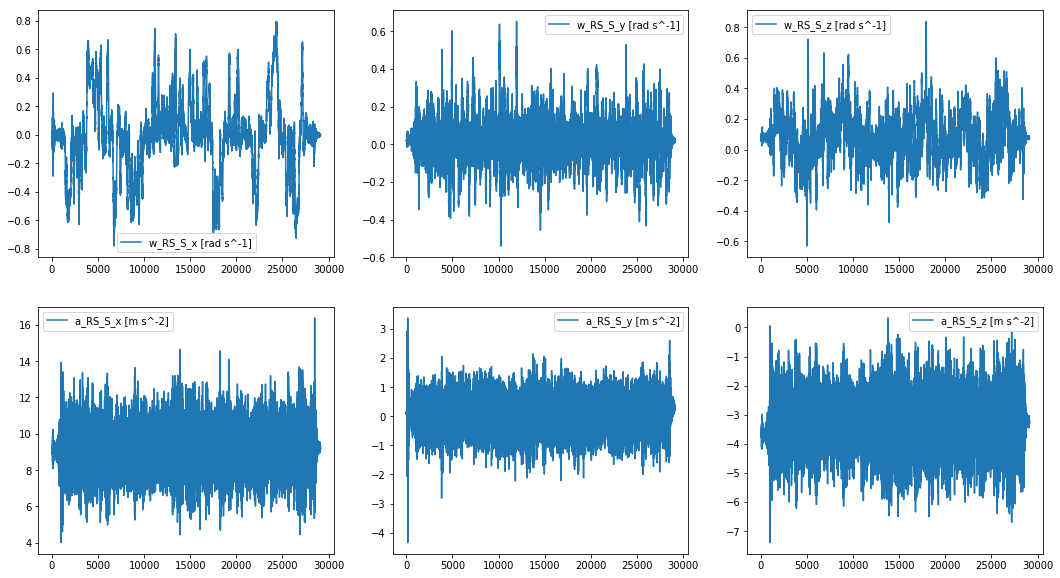

In [4]:
fig1, axes1 = plt.subplots(nrows=2, ncols=3, figsize=(18,10), squeeze=False)

df_stats.plot(kind="line", y="w_RS_S_x [rad s^-1]", ax=axes1[0,0])
df_stats.plot(kind="line", y="w_RS_S_y [rad s^-1]", ax=axes1[0,1])
df_stats.plot(kind="line", y="w_RS_S_z [rad s^-1]", ax=axes1[0,2])
df_stats.plot(kind="line", y="a_RS_S_x [m s^-2]", ax=axes1[1,0])
df_stats.plot(kind="line", y="a_RS_S_y [m s^-2]", ax=axes1[1,1])
df_stats.plot(kind="line", y="a_RS_S_z [m s^-2]", ax=axes1[1,2])

plt.show()

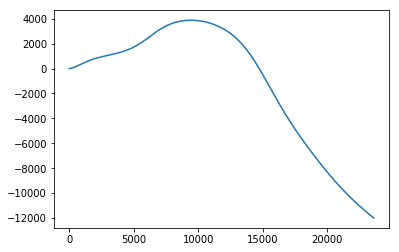

In [8]:
fun = Preintegrated()
x = []
y = []

for i in range(len(df_stats["w_RS_S_x [rad s^-1]"])):
    if i == 0:
        gyro_0 = np.array([[df_stats["w_RS_S_x [rad s^-1]"][i]], [df_stats["w_RS_S_y [rad s^-1]"][i]], [df_stats["w_RS_S_z [rad s^-1]"][i]]])
        acc_0 = np.array([[df_stats["a_RS_S_x [m s^-2]"][i]], [df_stats["a_RS_S_y [m s^-2]"][i]], [df_stats["a_RS_S_z [m s^-2]"][i]]])
        t0 = df_stats["#timestamp [ns]"][i]
        continue
    
    gyro_m = np.array([[df_stats["w_RS_S_x [rad s^-1]"][i]], [df_stats["w_RS_S_y [rad s^-1]"][i]], [df_stats["w_RS_S_z [rad s^-1]"][i]]])
    acc_m = np.array([[df_stats["a_RS_S_x [m s^-2]"][i]], [df_stats["a_RS_S_y [m s^-2]"][i]], [df_stats["a_RS_S_z [m s^-2]"][i]]])
    dt = (df_stats["#timestamp [ns]"][i] - df_stats["#timestamp [ns]"][i-1])/1e9  #s
    fun.IntergrateNewMeasurement(acc_m,gyro_m,dt)
    x.append(fun.dP[0,0])
    y.append(fun.dP[1,0])

plt.plot(x, y)
plt.show()

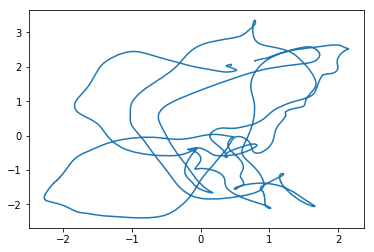

In [10]:
x = []
y = []
for i in range(len(ground_truch_data["#timestamp"])):
    x.append(ground_truch_data["x"][i])
    y.append(ground_truch_data["y"][i])
    
plt.plot(x, y)
plt.show()